In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import json
import time
import itertools as it
import sys
sys.path.append('lib')
from analysis_utils import *

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Todo 
- make PR_type a string for all versions

In [24]:
def combine(*vs):
    def loop():
        first_pid = 0
        for v in vs:
            df = pd.read_csv('data/human/0.{}/mouselab-mdp.csv'.format(v))
            pdf = pd.read_csv('data/human/0.{}/participants.csv'.format(v))
            df.pid += first_pid
            pdf.pid += first_pid
            first_pid += max(pdf.pid.max(), df.pid.max()) + 1
            yield df, pdf
    dfs, pdfs = zip(*loop())
    df = pd.concat(dfs).reset_index()
    pdf = pd.concat(pdfs).reset_index().set_index('pid', drop=False)
    return df, pdf

df, pdf = combine(6)

completed = list(pdf.query('completed').pid)
df = df.query('pid == @completed')
pdf = pdf.query('pid == @completed')

df.trial_index = df.trial_index.astype(int)
df.trial_i = df.trial_i.astype(int)
df['version'] = list(pdf.version.loc[df.pid])
df['info_cost'] = list(pdf.info_cost.loc[df.pid])
df['PR_type'] = list(pdf.PR_type.loc[df.pid])

from toolz.curried import *
from ast import literal_eval
df['clicks'] = df.queries.apply(literal_eval).apply(
    lambda x: np.array(x['click']['state']['target'])
)
df['click_times'] = df.queries.apply(literal_eval).apply(
    lambda x: np.array(x['click']['state']['time'])
)
df.action_times = df.action_times.apply(literal_eval)
df['n_click'] = df.clicks.apply(len)
df.delays = df.delays.apply(literal_eval)

pdf['time'] = df.groupby('pid').time_elapsed.max() / 60000
pdf.score = df.groupby('pid').score.sum()

In [25]:
# identifiers = pd.read_csv('data/human_raw/0.6/identifiers.csv')
# pdf = pdf.join(identifiers.set_index('pid'))
# sys.path.append('bin')
# from compensation import Compensator
# comp = Compensator()
# for i, row in pdf.iterrows():
#     comp.approve(row.assignment_id)
#     if row.bonus > 0:
#         comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))

In [26]:
def before_first(row):
    try:
        a1 = row.action_times[0]
        return sum(row.click_times < a1)
    except:
        return None

df['early_click'] = df.apply(before_first, axis=1)

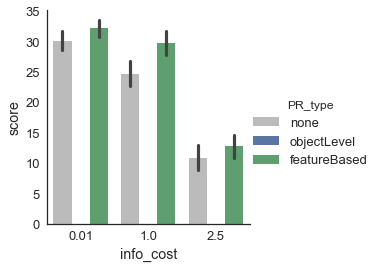

In [27]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = 'none objectLevel featureBased'.split()
# PR_ORDER = ['objectLevel', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df, 
               kind='bar', hue_order=PR_ORDER)

In [28]:
pi_star

,0.01,1.6,2.8
0,39.87,24.0,23.2
1,45.89,9.8,12.6
2,33.86,18.0,-6.8
3,33.86,18.0,20.0
4,41.88,26.0,4.8
5,33.84,16.4,-7.4
6,37.86,-2.4,-11.6
7,33.84,21.2,2.4
8,40.84,28.2,32.6
9,36.84,22.6,28.6


In [32]:
optimal = pd.read_csv('data/stimuli/exp1/optimal.csv', header=None)[0]
df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal

df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

pi_star = pd.read_csv('data/stimuli/exp1/score_pi_star.csv', header=None)
pi_star.columns = [0.01, 1.00, 2.50]
worst = pd.read_csv('data/stimuli/exp1/worst.csv', header=None)[0]
worst

0     -2
1      3
2      5
3      1
4      2
5      3
6      7
7      3
8     11
9      4
10     0
11     7
Name: 0, dtype: int64

In [17]:
# (R-R_min)/(R_max-R_min)
r_min = worst.loc[df.trial_i].as_matrix()
df['pi_star'] = pi_star.stack()[df[['trial_i', 'info_cost']].as_matrix()].as_matrix()
r_max = df.optimal
r = df.score
df['relative_score'] = (r - r_min) / (r_max - r_min)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

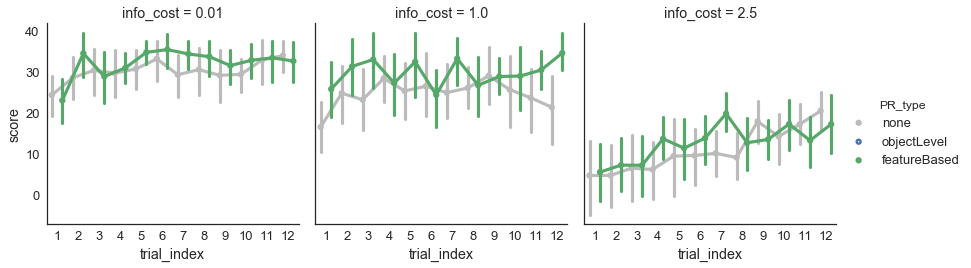

In [20]:
sns.factorplot('trial_index', 'score', hue='PR_type', data=df,
               col='info_cost', size=4,
               dodge=.5, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

In [246]:
rdf = df2r(df, 
           ['info_cost', 'trial_index', 'score', 'n_click', 'pid', 'trial_i', 'PR_type'])

In [243]:
%%R -i rdf
require(lme4)
require(car)
# rdf$info_cost = as.factor(rdf$info_cost)
Anova(lmer('score ~ trial_index * PR_type + (1|pid) + (1|trial_i)', 
           data=rdf
           # data=subset(rdf, info_cost == 2.80)
                      ))


Error in eval(expr, envir, enclos) : object 'PR_type' not found


/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'PR_type' not found

  warnings.warn(x, RRuntimeWarning)


In [238]:
%%R -i rdf
summary(lm('score ~ info_cost * trial_index * PR_type', 
           data=subset(rdf, info_cost > 0)
                      ))


Error in eval(expr, envir, enclos) : object 'PR_type' not found


In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55
